# NMF Practical Work

**Roland Badeau - Notebook code by Umut Simsekli** 

Practical work by Daniel Deutsch and Kevin Kühl

Telecom Paris - TSIA 206

### Question 1 - Derivation of MUR for NMF considering $\beta$-divergence

We firt write the $\beta-divergence$ distance function as follows

$$d_{\beta}(x||\hat{x})=\frac{x^{\beta}}{\beta(\beta-1)} - \frac{x\hat{x}^{\beta-1}}{\beta-1} + \frac{\hat{x}^{\beta}}{\beta}$$

Now we consider as cost the sum of distances applied to all the elements in two matrices, which is written as

$$\sum_{i,j}d_{\beta}(x_{ij}||\hat{x_{ij}}) = \sum_{i,j}\frac{x_{ij}^{\beta}}{\beta(\beta-1)} - \frac{x_{ij}\hat{x_{ij}}^{\beta-1}}{\beta-1} + \frac{\hat{x_{ij}}^{\beta}}{\beta}$$

But $\hat{x_{ij}}$ can be written as $\hat{x_{ij}} = \sum_{k}w_{ik}h_{kj}$

Therefore we write the cost as C

$$C = \sum_{i,j}\frac{x_{ij}^{\beta}}{\beta(\beta-1)} - \frac{x_{ij}(\sum_{k}w_{ik}h_{kj})^{\beta-1}}{\beta-1} + \frac{(\sum_{k}w_{ik}h_{kj})^{\beta}}{\beta}$$

In order to minimize the cost we consider an algorithm similar to the gradient descent (but with variable stepsize). Therefore, the gradient w.r.t $w_{ij}$ can be computed as

$$g_{w_{ik}} = \frac{\partial C}{\partial w_{ik}} = \sum_{j}-\frac{x_{ij}(\beta - 1)(\hat{x_{ij}})^{\beta-2}(h_{kj})}{\beta-1} + \frac{\beta(\hat{x_{ij}})^{\beta - 1}(h_{kj})}{\beta}$$

Considering the update rule

$$w_{ik} = w_{ik} - \alpha g_{w_{ik}}$$

And setting

$$\alpha = \frac{w_{ik}}{\sum_{j}\hat{x}^{\beta-1}_{ij}(h_{kj})}$$

We get for the update rule

$$w_{ik} = w_{ik} - \frac{w_{ik}}{\sum_{j}\hat{x}^{\beta-1}_{ij}(h_{kj})}\sum_{j}-\frac{x_{ij}(\beta - 1)(\hat{x_{ij}})^{\beta-2}(h_{kj})}{\beta-1} + \frac{\beta(\hat{x_{ij}})^{\beta - 1}(h_{kj})}{\beta}$$

$$w_{ik} = w_{ik}(1 - 1 + \frac{\sum_{j}x_{ij}(\hat{x_{ij}})^{\beta-2}(h_{kj})}{\sum_{j}\hat{x}^{\beta-1}_{ij}(h_{kj})})$$

Which finally allow us to write

$$W \leftarrow W \circ \frac{(X \circ \hat{X}^{\beta-2})H^T}{\hat{X}^{\beta-1}H^{T}}$$

Acting similarly for matrix H

$$g_{h_{kj}} = \frac{\partial C}{\partial h_{kj}} = \sum_{i}-\frac{x_{ij}(\beta - 1)(\hat{x_{ij}})^{\beta-2}(w_{ik})}{\beta-1} + \frac{\beta(\hat{x_{ij}})^{\beta - 1}(w_{ik})}{\beta}$$

Considering the update rule

$$h_{kj} = h_{kj} - \alpha g_{h_{kj}}$$

And setting

$$\alpha = \frac{h_{kj}}{\sum_{j}\hat{x}^{\beta-1}_{ij}(w_{ik})}$$

Which will similarly yield

$$H \leftarrow H \circ \frac{W^T(X \circ \hat{X}^{\beta-2})}{W^T\hat{X}^{\beta-1}}$$

On the below implementation, the version considering also a stepsize $\eta$ is coded.

### Question 2

In [1]:
import numpy as np

# matplotlib for displaying the output
import matplotlib.pyplot as plt
import matplotlib.style as ms
ms.use('seaborn-muted')
from IPython.display import display, clear_output
%matplotlib inline

# and IPython.display for audio output
import IPython.display as ipd

# Librosa for audio
import librosa
# # And the display module for visualization
import librosa.display


<Figure size 432x288 with 0 Axes>

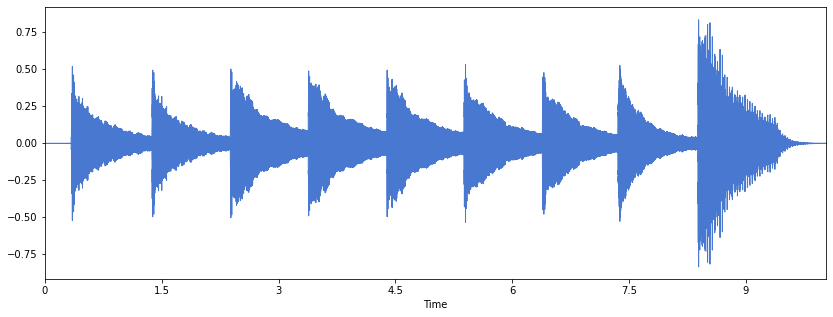

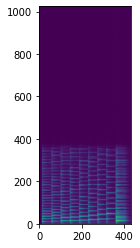

In [2]:
# Audio file
fname = 'Cmajor_piano8khz.wav'

# Load signal
y, sr = librosa.load(fname)

# Compute STFT
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = np.abs(Xstft)

#Visualize the waveform
plt.figure()
plt.figure(figsize=(14, 5))
librosa.display.waveplot(y, sr=sr)

#Visualize the spectrum
plt.figure()
plt.imshow(X**0.3)
plt.gca().invert_yaxis()


In [3]:
ipd.Audio(y, rate=sr)

In [4]:
def beta_divergence(V,V_hat,beta):
    cost = 0
    F = V.shape[0]
    N = V.shape[1]
    for f in range(F):
        for n in range(N):
            cost += (1/((beta)*(beta-1)))*(V[f,n]**beta + (beta-1)*V_hat[f,n]**beta - beta*V[f,n]*V_hat[f,n]**(beta-1))
    return cost

In [5]:
# Implement MUR for NMF with beta-divergence 
def NMF_MUR(V, beta, k, epsilon=0.005, eta=1):
    F = V.shape[0]
    N = V.shape[1]
    W = np.random.rand(F,k)
    H = np.random.rand(k,N)
    V_hat = np.matmul(W,H)
    costs = [1.1*beta_divergence(V,V_hat,beta),beta_divergence(V,V_hat,beta)]
    while np.abs((costs[-1]-costs[-2])/costs[-2])>epsilon:
        W = W * np.power((((V * np.power((W.dot(H) + 10e-10),beta-2)).dot(H.transpose())) / ((np.power((W.dot(H) + 10e-10),beta-1)).dot(H.transpose()))),eta)
        H = H * np.power((((W.transpose()).dot((V * np.power((W.dot(H) + 10e-10),beta-2)))) / (((W.transpose()).dot(np.power((W.dot(H)) + 10e-10,beta-1))))),eta)
        V_hat = np.matmul(W,H)
        costs.append(beta_divergence(V,V_hat,beta))
        print(f"Current Divergence: {costs[-1]:.3f}    -    Previous Divergence: {costs[-2]:.3f}    -    Variation: {np.abs((costs[-1]-costs[-2])/costs[-2])*100:.3f}%    ", end = "\r")
    return W,H,costs[2:]

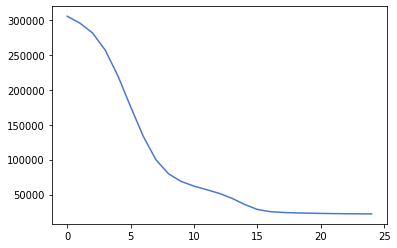

In [6]:
W, H, costs = NMF_MUR(X,1.5,8)
plt.plot(costs)

In [7]:
# Use Wiener filtering to reconstruct each note separately
def reconstruct_source(X, W, H, source):
    return X*np.divide(np.matmul(W[:,source].reshape(-1,1),H[source,:].reshape(1,-1)),np.matmul(W,H)+10e-10)

X_source = reconstruct_source(Xstft, W, H, 2)

# Example reconstruction
y_hat = librosa.istft(X_source)
ipd.Audio(y_hat, rate=sr)


In [8]:
# Reconstructing everything
k = 8
X_reconstructed = reconstruct_source(Xstft, W, H, 0)
for i in range(1,8):
    X_reconstructed += reconstruct_source(Xstft, W, H, i)
y_hat = librosa.istft(X_reconstructed)
ipd.Audio(y_hat, rate=sr)

# Question 3 - Experimenting with different parameter beta and eta (1.8; 1.3)

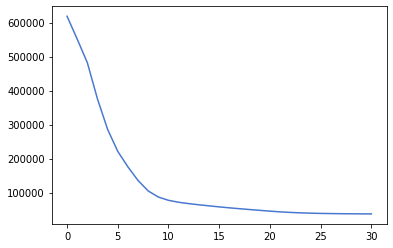

In [9]:
# To grant convergence, we must have beta < 2
W, H, costs = NMF_MUR(X,1.8,8,eta=1.3)
plt.plot(costs)

In [10]:
X_source_0 = reconstruct_source(Xstft, W, H, 0)

y_hat = librosa.istft(X_source_0)
ipd.Audio(y_hat, rate=sr)

In [11]:
X_source_1 = reconstruct_source(Xstft, W, H, 1)

y_hat = librosa.istft(X_source_1)
ipd.Audio(y_hat, rate=sr)

In [12]:
X_source_2 = reconstruct_source(Xstft, W, H, 2)

y_hat = librosa.istft(X_source_2)
ipd.Audio(y_hat, rate=sr)

In [13]:
X_source_3 = reconstruct_source(Xstft, W, H, 3)

y_hat = librosa.istft(X_source_3)
ipd.Audio(y_hat, rate=sr)

In [14]:
X_source_4 = reconstruct_source(Xstft, W, H, 4)

y_hat = librosa.istft(X_source_4)
ipd.Audio(y_hat, rate=sr)

In [15]:
X_source_5 = reconstruct_source(Xstft, W, H, 5)

y_hat = librosa.istft(X_source_5)
ipd.Audio(y_hat, rate=sr)

In [16]:
X_source_6 = reconstruct_source(Xstft, W, H, 6)

y_hat = librosa.istft(X_source_6)
ipd.Audio(y_hat, rate=sr)

In [17]:
X_source_7 = reconstruct_source(Xstft, W, H, 7)

y_hat = librosa.istft(X_source_7)
ipd.Audio(y_hat, rate=sr)

It is observed that the convergence is a little faster for higher values of eta (but it is not granted for all values of eta). Also, the value of beta seems to have little impact in final's result quality. Also, the different period to converge may be due to the random initialization of W and H matrices.

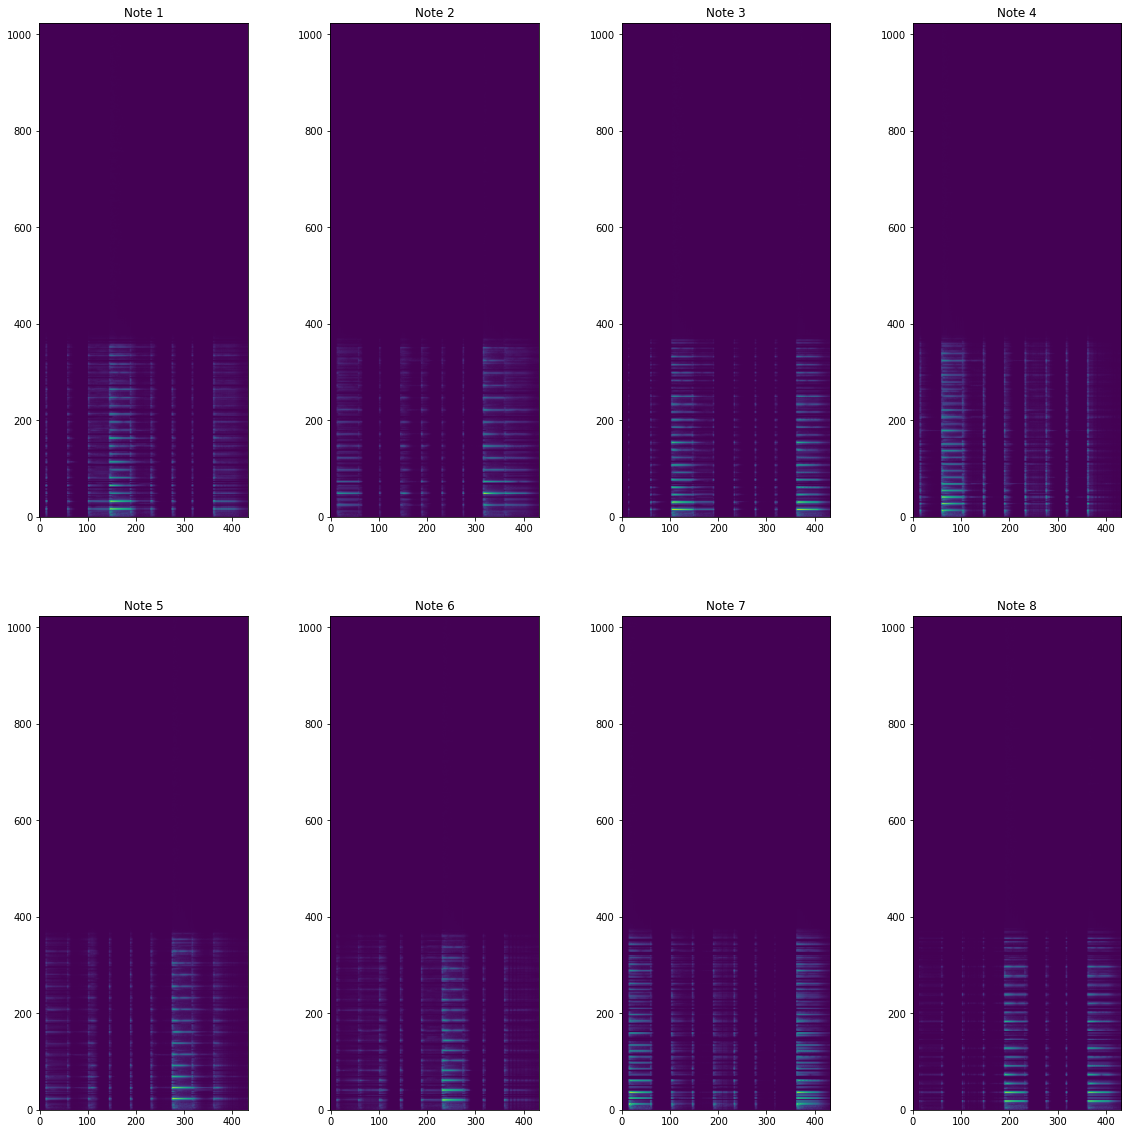

In [18]:
fig, ax = plt.subplots(2,4, figsize=(20,20))

ax[0,0].imshow(abs(X_source_0)**0.3)
ax[0,0].set_title("Note 1")
ax[0,0].invert_yaxis()

ax[0,1].imshow(abs(X_source_1)**0.3)
ax[0,1].set_title("Note 2")
ax[0,1].invert_yaxis()

ax[0,2].imshow(abs(X_source_2)**0.3)
ax[0,2].set_title("Note 3")
ax[0,2].invert_yaxis()

ax[0,3].imshow(abs(X_source_3)**0.3)
ax[0,3].set_title("Note 4")
ax[0,3].invert_yaxis()

ax[1,0].imshow(abs(X_source_4)**0.3)
ax[1,0].set_title("Note 5")
ax[1,0].invert_yaxis()

ax[1,1].imshow(abs(X_source_5)**0.3)
ax[1,1].set_title("Note 6")
ax[1,1].invert_yaxis()

ax[1,2].imshow(abs(X_source_6)**0.3)
ax[1,2].set_title("Note 7")
ax[1,2].invert_yaxis()

ax[1,3].imshow(abs(X_source_7)**0.3)
ax[1,3].set_title("Note 8")
ax[1,3].invert_yaxis()

plt.show()

Now if we change parameters in the STFT and look for different number of sources

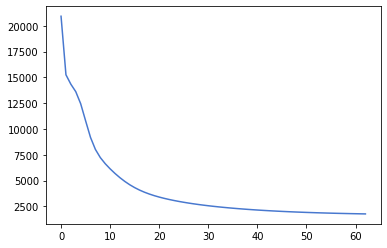

In [26]:
# First the STFT parameters
Xstft = librosa.stft(y, n_fft=2048, hop_length=1024, win_length=256)
X = abs(Xstft)

# To grant convergence, we must have beta < 2
W, H, costs = NMF_MUR(X,1.8,8,eta=1.3)
plt.plot(costs)

In [27]:
X_source_1 = reconstruct_source(Xstft, W, H, 1)

y_hat = librosa.istft(X_source_1)
ipd.Audio(y_hat, rate=sr)

If we change STFT parameters we observe a change in time duration of the sound and also in its reconstructed signal, that becomes incomprehensible. In that case we experimented with a 1024 samples hop length and 256 samples window length.

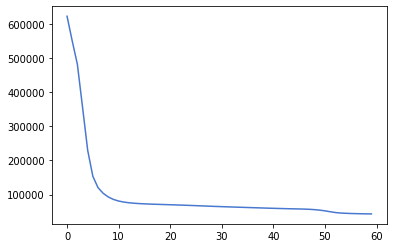

In [31]:
# Using original STFT parameters and changing number of expected sources
Xstft = librosa.stft(y, n_fft=2048, hop_length=512, win_length=None)
X = abs(Xstft)
W, H, costs = NMF_MUR(X,1.8,10,eta=1.3)
plt.plot(costs)

In [34]:
X_source_9 = reconstruct_source(Xstft, W, H, 9)

y_hat = librosa.istft(X_source_9)
ipd.Audio(y_hat, rate=sr)

When we input a different number of sources (different from the number we expect from listening to the sound) we obtain a worse reconstructed signal at the end. We believe this is due to the fact that intermediate frequencies to the notes played are considered sources, instead of the notes itself. This would be needed in order to produce more notes than there are in fact.